# Predicting High Side-Effect Burden Using NLP

**Goal:** predict whether a drug has a **high side-effect burden** using only *prescribing information text*:
- **Uses** (therapeutic indications)
- **Composition** (active ingredients)

**Why this matters:** With a pharmacy background, I wanted to test whether therapeutic indications and active ingredients already contain enough signal to predict a rough proxy of side-effect burden. This is not a clinical prediction model — it’s a text-to-signal experiment on a public dataset using simple NLP features.

**The main lesson:** Evaluation can be misleading when the same composition appears under many products, so group-based splitting is essential.

**Dataset:** Medicine_Details.csv (drug name, composition, uses, side effects, review percentages).


## 1. Setup

We import libraries and load the dataset from the project folder.

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## 2. Data loading and basic filtering

We keep only the columns needed for modeling and drop rows with missing values in critical fields.
We also report how many duplicate compositions exist (important for leakage-aware evaluation later).

In [2]:
data_path = "data/Medicine_Details.csv"

df = pd.read_csv(data_path)
print("Loaded:", df.shape)
df.head(3)

use_cols = ["Medicine Name", "Composition", "Uses", "Side_effects"]
df = df[use_cols].copy()

df = df.dropna(subset=["Composition", "Uses", "Side_effects"]).reset_index(drop=True)

dup_comp = df.duplicated(subset=["Composition"]).sum()
print("Duplicate compositions:", dup_comp, f"({dup_comp/len(df):.1%} of rows)")
print("Rows after dropna:", df.shape)

Loaded: (11825, 9)
Duplicate compositions: 8467 (71.6% of rows)
Rows after dropna: (11825, 4)


## 3. Target definition: High side-effect burden

**Side-effect burden** is approximated as the **count of listed side effects** in the `Side_effects` field.
Side effects are inconsistently formatted in the dataset, so a heuristic approach is used:
1) split by commas / semicolons if available  
2) otherwise split by capital letters as a fallback  

We define:
- `high_se_burden = 1` if `num_side_effects` is in the **top 25%** of the dataset
- otherwise `0`

> Note: this is a *volume-based proxy*, not severity or incidence.

In [3]:
def count_side_effects(s) -> int:
    if pd.isna(s):
        return 0

    text = str(s).strip()
    text = re.sub(r"\s+", " ", text)

    parts = re.split(r"[,\n;]+", text)
    parts = [p.strip() for p in parts if p.strip()]
    if len(parts) > 1:
        return len(parts)

    parts = re.split(r"\s(?=[A-Z])", text)
    parts = [p.strip() for p in parts if p.strip()]
    return len(parts)

df["num_side_effects"] = df["Side_effects"].apply(count_side_effects)
print(df["num_side_effects"].describe())

threshold_se = df["num_side_effects"].quantile(0.75)
df["high_se_burden"] = (df["num_side_effects"] >= threshold_se).astype(int)

print("Threshold (75th percentile):", threshold_se)
print(df["high_se_burden"].value_counts(normalize=True))

count    11825.000000
mean         6.916702
std          4.303492
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         36.000000
Name: num_side_effects, dtype: float64
Threshold (75th percentile): 9.0
high_se_burden
0    0.71518
1    0.28482
Name: proportion, dtype: float64


Manual spot-check (5 random samples) suggests the counting heuristic is reasonable for this dataset, though it remains a proxy.

In [4]:
df_sanity = df[["Medicine Name", "Side_effects", "num_side_effects"]].sample(5, random_state=42)
df_sanity

,Medicine Name,Side_effects,num_side_effects
8169,Q-Pin SR 200 Tablet,Dizziness Dryness in mouth Sleepiness Constipa...,8
900,Abel-CT 40mg/12.5mg Tablet,Dizziness Tiredness Decreased potassium level ...,6
8075,Piopar 7.5 Tablet,Headache Sore throat Sinus inflammation Muscle...,4
7625,Pbren 50 Capsule,Blurred vision Difficulty in paying attention ...,7
2816,Gestofit 300mg SR Tablet,Abdominal pain Nausea Abnormal vaginal bleedin...,10


### 3.1 Distribution of side-effect counts


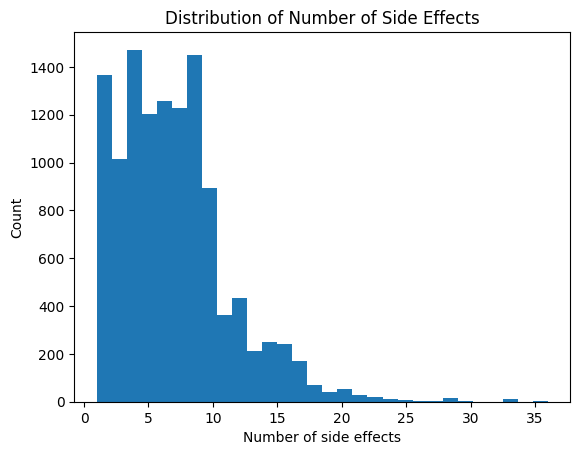

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["num_side_effects"], bins=30)
plt.title("Distribution of Number of Side Effects")
plt.xlabel("Number of side effects")
plt.ylabel("Count")
plt.show()

The distribution is right-skewed, with a median around 6 and the 75th percentile at 9 side effects.
This supports the use of the top quartile as a threshold for defining high side-effect burden.

## 4. Text preprocessing and TF-IDF features

We build the input text from **Uses + Composition** (information available before using the side effects list).
We also remove dosage tokens and numbers (e.g., "500mg") to avoid superficial patterns.

Then we convert text into TF-IDF features (uni-grams + bi-grams).

In [6]:
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"\d+\s*mg", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["combined_text"] = (df["Uses"].fillna("") + " " + df["Composition"].fillna("")).apply(clean_text)

X_text_raw = df["combined_text"]
y = df["high_se_burden"]
groups = df["Composition"]

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=2000,
    ngram_range=(1, 2),
    min_df=2
)

X = tfidf.fit_transform(X_text_raw)
print("TF-IDF matrix:", X.shape)

TF-IDF matrix: (11825, 2000)


## 5. Baseline evaluation (random split)

We train an interpretable baseline model:
- **Logistic Regression** with `class_weight="balanced"`
- metric: **ROC-AUC** (threshold-independent)

This random split is a baseline, but it may be optimistic when there are repeated compositions.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=3000, class_weight="balanced")
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("Random split ROC-AUC:", roc_auc_score(y_test, y_prob))

Random split ROC-AUC: 0.9804357858939015


## 6. Leakage-aware evaluation (Group split by Composition)

Many drugs share the same **Composition**.
To avoid overly optimistic estimates, we perform a **group split** where the same composition cannot appear in both train and test.

This is a more realistic evaluation of generalization.

In [8]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train_g, X_test_g = X[train_idx], X[test_idx]
y_train_g, y_test_g = y.iloc[train_idx], y.iloc[test_idx]

model_group = LogisticRegression(max_iter=3000, class_weight="balanced")
model_group.fit(X_train_g, y_train_g)

y_prob_group = model_group.predict_proba(X_test_g)[:, 1]

print("Group split ROC-AUC:", roc_auc_score(y_test_g, y_prob_group))
print("Test size:", len(test_idx))
print("Class balance in group test:", y_test_g.value_counts(normalize=True).to_dict())

Group split ROC-AUC: 0.9581440817043675
Test size: 2546
Class balance in group test: {0: 0.7089552238805971, 1: 0.291044776119403}


### 6.1 ROC Curve (Group Split)

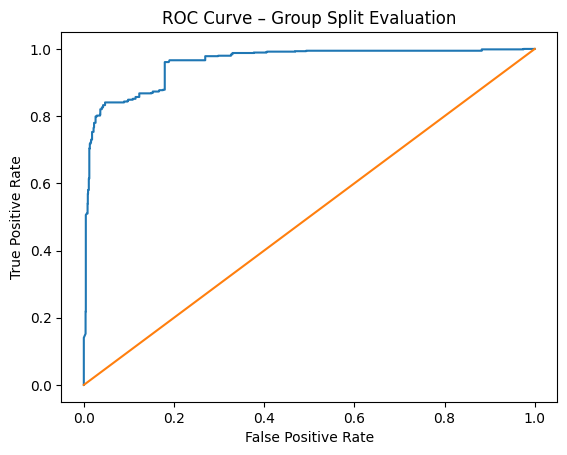

In [9]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test_g, y_prob_group)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.title("ROC Curve – Group Split Evaluation")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The ROC curve remains well above the diagonal, confirming strong separability even under leakage-aware group splitting.

In [10]:
def eval_group_split_auc(X, y, groups, seed: int) -> float:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    train_idx, test_idx = next(gss.split(X, y, groups=groups))

    X_train_g, X_test_g = X[train_idx], X[test_idx]
    y_train_g, y_test_g = y.iloc[train_idx], y.iloc[test_idx]

    model = LogisticRegression(max_iter=3000, class_weight="balanced")
    model.fit(X_train_g, y_train_g)
    y_prob_g = model.predict_proba(X_test_g)[:, 1]
    return roc_auc_score(y_test_g, y_prob_g)

seeds = [1, 42, 123]
group_aucs = [eval_group_split_auc(X, y, groups, s) for s in seeds]

print("Group split AUCs:", group_aucs)
print("Mean group AUC:", float(np.mean(group_aucs)))
print("Std group AUC:", float(np.std(group_aucs)))

Group split AUCs: [np.float64(0.8880994671403197), np.float64(0.9581440817043675), np.float64(0.9571213915567389)]
Mean group AUC: 0.9344549801338088
Std group AUC: 0.032780956488502676


The variability across seeds suggests that performance depends on how compositions are distributed across splits, reinforcing the importance of leakage-aware evaluation.

## 7. Summary and limitations

**Results (this run):**
- Random split ROC-AUC ≈ 0.98. This estimate is likely optimistic because many rows share the same composition (multiple brands/forms), so similar texts appear in both train and test.
- Group split ROC-AUC ≈ 0.89–0.96, mean 0.93 ± 0.03 (depends on how compositions are distributed)

**Limitations:**
- Side-effect burden is approximated by *count*, not severity or frequency.
- The dataset is not patient-level clinical data.
- `num_side_effects` may also reflect how extensively a drug has been studied (pharmacovigilance depth).

**Key takeaway:**
- Built an NLP pipeline (cleaning → TF-IDF → Logistic Regression)
- Designed a proxy target and sanity-checked it
- Used leakage-aware evaluation via GroupShuffleSplit

This project reflects iterative problem refinement and careful evaluation design rather than pure model optimization.


**Next steps:**
- Try additional models (Linear SVM, calibrated models).
- Add error analysis (which drug classes are harder).
- Validate on a different dataset (external validation).